In [1]:
#@title Import Data
#@markdown - upload the folder aml-task5 into your google drive
#@markdown - change the runtime to gpu (is faster than tpu)
#@markdown - run this cell to import the data (to see the code: right mouse click / form / show code )


# First remember to change runtime to GPU !!

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#COLAB
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [ ]:
import os
#Upload on drive fist the data folder called "data"
os.chdir("/content/drive/aml-task5")

In [3]:
!pip install cvxopt
!pip install pystruct

    100% |████████████████████████████████| 5.6MB 7.3MB/s 
    100% |████████████████████████████████| 675kB 23.0MB/s 
  Running setup.py bdist_wheel for pystruct ... done
  Stored in directory: /root/.cache/pip/wheels/d4/47/c8/18233d60780a14437cf42d8598ba553c0fefc832c0827c42fe
Successfully built pystruct


In [ ]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
#import pyeeg

from scipy import signal
from scipy.signal import (welch, medfilt, wiener,savgol_filter)
from scipy.integrate import simps

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (StratifiedKFold, KFold)

from sklearn.metrics import (accuracy_score, make_scorer, balanced_accuracy_score, roc_auc_score, mean_squared_error)

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.metrics import confusion_matrix

from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM
from pystruct.learners import OneSlackSSVM

from sklearn.ensemble import VotingClassifier

from statistics import median
seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()
# https://en.wikipedia.org/wiki/Neural_oscillation
SAMPLE_PER_SEC = 128
SAMPLE_PER_RAT = 21600
DELTA_WAVE = [1, 4]
THETA_WAVE = [4, 8]
ALPHA_WAVE = [7.5, 12.5]
BETA_WAVE = [13, 30]
TOTAL_ENERGY = [0, 64]
# not used
LOW_GAMMA_WAVE = [30, 70]
HIGH_GAMMA_WAVE = [70, 150]

EPSILON =  0.0002
FILTER_WINDOW = 5

In [ ]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
def check_for_floats(Array):
    for row in Array:
        for el in row:
            if isinstance(el, float):
                print(el)
                
def from_label_to_vec(labels):
    labels_vec = []
    for l in labels:
        if l == 1:
            labels_vec.append([1,0,0])
        elif l == 2:
            labels_vec.append([0,1,0])
        elif l == 3:
            labels_vec.append([0,0,1])
    return np.array(labels_vec)

                
def from_vec_to_labels(vecs):
    labels = []
    for v in vecs:
        if v[0] == 1:
            labels.append(1)
        elif v[1] == 1:
            labels.append(2)
        elif v[2] == 1:
            labels.append(3)
    return labels
  
def count_labels(labels):
    classes_cnt = [0,0,0]
    for l in labels:
        classes_cnt[l-1]+=1
    print(classes_cnt)

In [7]:
# LOAD THE FEATURES FROM CSV
X_train = pd.read_csv("features/all_combined_train.csv").values
y_train = np.ravel(pd.read_csv("features/all_combined_label.csv").values)
X_test = pd.read_csv("features/all_combined_test.csv").values

print("X train final shape -> ",X_train.shape)
print("X test final shape -> ",X_test.shape)
#Fit scaler on all data
X_total = np.concatenate((X_train, X_test))
print("X total shape -> ", X_total.shape)

scaler = StandardScaler().fit(X_total)

data_dim = X_train.shape[1]
timesteps = SAMPLE_PER_RAT
num_classes = 3
batch_size = 32

X train final shape ->  (64800, 49)
X test final shape ->  (43200, 49)
X total shape ->  (108000, 49)


In [11]:
# CRF

print("Starting CRF...")

weights_crf = compute_class_weight("balanced", classes, y_train)
weights_crf[0] = weights_crf[0]+2.5
weights_crf[1] = weights_crf[1]+1.5

X_train_crf = X_train.reshape(3, -1, 49)
y_train_crf = y_train.reshape(3,-1) -1
    
X_test_crf = X_test.reshape(2, -1, 49)

model = ChainCRF(class_weight=weights_crf)
ssvm = OneSlackSSVM(model=model, C=0.1, max_iter=2000)
    
ssvm.fit(X_train_crf, y_train_crf)   
   
y_pred_crf = ssvm.predict(X_test_crf)
y_pred_crf = np.asarray(y_pred_crf).reshape(-1) + 1  
y_pred_filtered_crf = medfilt(y_pred_crf, FILTER_WINDOW)


print(f"CRF unique predictions{np.unique(y_pred_filtered_crf)}")


# SVC
print("Running SVC...")
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(class_weight="balanced", random_state=seed, C=0.01, verbose=False, gamma=0.0004)
svc.fit(X_train_scaled, y_train)

y_pred_svc = svc.predict(X_test_scaled)      
y_pred_filtered_svc = medfilt(y_pred_svc, FILTER_WINDOW)

print(f"SVC unique predictions{np.unique(y_pred_filtered_svc)}")

# LSTM
print("Running LSTM...")
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)
EPOCHS=20
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(np.array([0,1,2]), weights))
lstm_predictions = []


X_test_scaled = scaler.transform(X_test)
X_test_scaled_lstm = np.reshape(X_test_scaled, (2 * timesteps, 1, data_dim))

for train, valid in kfold.split(X_train):
    print("  start fold")
    X_train_fold = X_train[train]
    y_train_fold = y_train[train]
    
    X_valid_fold = X_train[valid]
    y_valid_fold = y_train[valid]

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_valid_fold_scaled = scaler.transform(X_valid_fold)
    
    
    X_train_fold_scaled_lstm = np.reshape(X_train_fold_scaled, (2 * timesteps, 1, data_dim))
    y_train_fold_lstm = from_label_to_vec(y_train_fold)
    
    X_valid_fold_scaled_lstm= np.reshape(X_valid_fold_scaled, (timesteps, 1, data_dim))
    y_valid_fold_lstm = from_label_to_vec(y_valid_fold)


    model = Sequential()
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, stateful=True))
    model.add(Dense(num_classes, activation='softmax'))
    

    model.compile(loss=weighted_categorical_crossentropy(weights),
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.fit(X_train_fold_scaled_lstm, y_train_fold_lstm,
              class_weight=cw,
              verbose=0,
              batch_size=batch_size, epochs=EPOCHS, shuffle=False,
              validation_data=(X_valid_fold_scaled_lstm, y_valid_fold_lstm))
    
    
    
    y_pred_lstm = model.predict(X_test_scaled_lstm)
     
    lstm_predictions.append(y_pred_lstm)

    
y_pred_lstm = (lstm_predictions[0] + lstm_predictions[1] + lstm_predictions[2])/3.0
labels = []
for p in y_pred_lstm:
    labels.append(np.argmax(p)+1)
    y_pred_lstm = np.array(labels)   
    
y_pred_filtered_lstm = medfilt(y_pred_lstm, FILTER_WINDOW)

print(f"LSTM unique predictions{np.unique(y_pred_filtered_lstm)}")



# Voting

print("Starting Voting Filtered...")
y_pred_filtered_voting = np.array([])
for i in range(0,y_pred_filtered_crf.shape[0]):
  y_pred_filtered_voting = np.append(y_pred_filtered_voting, median([y_pred_filtered_svc[i],  y_pred_filtered_lstm[i], y_pred_filtered_crf[i]]))
y_pred_filtered_voting = medfilt(y_pred_filtered_voting, FILTER_WINDOW)


submission_name = "nk_svc_lstm_crf_voting.csv"


y_pred_df = pd.DataFrame(y_pred_filtered_voting)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered_voting.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)


Starting CRF...
CRF unique predictions[1. 2. 3.]
Running SVC...
SVC unique predictions[1. 2. 3.]
Running LSTM...
  start fold
  start fold
  start fold
LSTM unique predictions[1. 2. 3.]
Starting Voting Filtered...


NameError: ignored

Starting Voting Filtered...


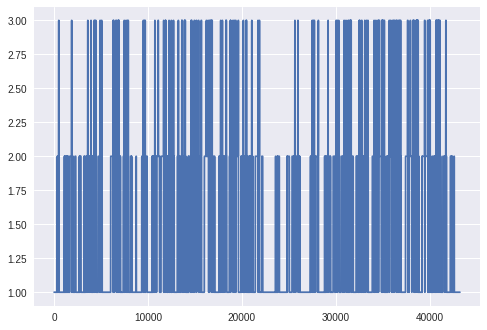

In [13]:
# Voting

print("Starting Voting Filtered...")
y_pred_filtered_voting = np.array([])
for i in range(0,y_pred_filtered_crf.shape[0]):
  y_pred_filtered_voting = np.append(y_pred_filtered_voting, median([y_pred_filtered_svc[i],  y_pred_filtered_lstm[i], y_pred_filtered_crf[i]]))
y_pred_filtered_voting = medfilt(y_pred_filtered_voting, FILTER_WINDOW)


submission_name = "nk_svc_lstm_crf_voting.csv"


y_pred_df = pd.DataFrame(y_pred_filtered_voting)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered_voting.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)

In [18]:


# CROSS VALDATION
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)

print("Start")
EPOCHS=20
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(np.array([0,1,2]), weights))

clf_scores_avg = []
clf_scores_std = []


bmac_d = {
    "svc":[],
    "lstm":[],
    "crf":[],
    "voting":[]
}

clf_d = {
    "svc":[],
    "lstm":[],
    "crf":[]
}

conf_d = {
    "svc":[],
    "lstm":[],
    "crf":[],
    "voting":[]
}

predictions_d = {
    "svc":[],
    "lstm":[],
    "crf":[],
    "voting":[]
}

weights_crf = compute_class_weight("balanced", classes, y_train)
weights_crf[0] = weights_crf[0]+2.5
weights_crf[1] = weights_crf[1]+1.5


for train, valid in kfold.split(X_train):
    # get the folds
    X_train_fold = X_train[train]
    y_train_fold = y_train[train]
    
    X_valid_fold = X_train[valid]
    y_valid_fold = y_train[valid]

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_valid_fold_scaled = scaler.transform(X_valid_fold)
    
    
    ### SVC
    print("Starting SVC...")
    svc = SVC(class_weight="balanced", 
          random_state=seed, 
          C=0.01,
          verbose=False,
          gamma=0.0004)
    
    svc.fit(X_train_fold_scaled, y_train_fold)
    y_pred_svc = svc.predict(X_valid_fold_scaled)      
    
    bmac = balanced_accuracy_score(y_valid_fold, y_pred_svc)
    conf = confusion_matrix(y_valid_fold, y_pred_svc)
    
    y_pred_svc_filtered = medfilt(y_pred_svc, FILTER_WINDOW)
    bmac_median =  balanced_accuracy_score(y_valid_fold,  y_pred_svc_filtered)
    conf_median = confusion_matrix(y_valid_fold,  y_pred_svc_filtered)
    
    bmac_d['svc'].append(bmac)
    clf_d['svc'].append(clf)
    conf_d['svc'].append(conf)
    predictions_d['svc'].append(y_pred_svc)
    
    print(f"Finished SVC:   bmac={bmac}   bmac_median={bmac_median}")
    display(conf)
    display(conf_median)
    
    ### LSTM 
    print("Starting LSTM...")
    X_train_fold_scaled_lstm = np.reshape(X_train_fold_scaled, (2 * timesteps, 1, data_dim))
    y_train_fold_lstm = from_label_to_vec(y_train_fold)
    
    X_valid_fold_scaled_lstm= np.reshape(X_valid_fold_scaled, (timesteps, 1, data_dim))
    y_valid_fold_lstm = from_label_to_vec(y_valid_fold)


    model = Sequential()
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, stateful=True))
    model.add(Dense(num_classes, activation='softmax'))
    

    model.compile(loss=weighted_categorical_crossentropy(weights),
                  optimizer='rmsprop',
                  metrics=['accuracy', 'categorical_accuracy'])
    
    model.fit(X_train_fold_scaled_lstm, y_train_fold_lstm,
              class_weight=cw,
              verbose=0,
              batch_size=batch_size, epochs=EPOCHS, shuffle=False,
              validation_data=(X_valid_fold_scaled_lstm, y_valid_fold_lstm))
    
    
    y_pred_lstm = model.predict(X_valid_fold_scaled_lstm)
    labels = []
    for p in y_pred_lstm:
        labels.append(np.argmax(p)+1)
    y_pred_lstm = np.array(labels)

    
    bmac = balanced_accuracy_score(y_valid_fold, y_pred_lstm)
    conf = confusion_matrix(y_valid_fold, y_pred_lstm)
    
    y_pred_lstm_filtered = medfilt(y_pred_lstm, FILTER_WINDOW)
    bmac_median =  balanced_accuracy_score(y_valid_fold,  y_pred_lstm_filtered)
    conf_median = confusion_matrix(y_valid_fold,  y_pred_lstm_filtered)
    
    bmac_d['lstm'].append(bmac)
    clf_d['lstm'].append(model)
    conf_d['lstm'].append(conf)
    predictions_d['lstm'].append(y_pred_lstm)
    
    print(f"Finished LSTM:   bmac={bmac}    bmac_median={bmac_median}")
    display(conf)
    display(conf_median)
   
  
  
    ### CRF
    print("Starting CRF...")
    X_train_fold_crf = X_train_fold.reshape(2, -1, 49)
    y_train_fold_crf = y_train_fold.reshape(2,-1) -1
    
    X_valid_fold_crf = X_valid_fold.reshape(1, -1, 49)
    y_valid_fold_crf = y_valid_fold.reshape(1,-1) -1

    
    model = ChainCRF(class_weight=weights_crf)
    ssvm = OneSlackSSVM(model=model, C=0.1, max_iter=2000)
    
    ssvm.fit(X_train_fold_crf, y_train_fold_crf)   
   
    y_pred_crf = ssvm.predict(X_valid_fold_crf)
    y_pred_crf = np.asarray(y_pred_crf).reshape(-1) + 1  

    bmac = balanced_accuracy_score(y_valid_fold, y_pred_crf)
    conf = confusion_matrix(y_valid_fold, y_pred_crf)
 
    
    y_pred_crf_filtered = medfilt(y_pred_crf, FILTER_WINDOW)
    bmac_median =  balanced_accuracy_score(y_valid_fold,  y_pred_crf_filtered)
    conf_median = confusion_matrix(y_valid_fold,  y_pred_crf_filtered)
    
    bmac_d['crf'].append(bmac)
    clf_d['crf'].append(ssvm)
    conf_d['crf'].append(conf)
    predictions_d['crf'].append(y_pred_crf)
    
    print(f"Finished CRF:   bmac={bmac}    bmac_median={bmac_median}")
    display(conf)
    display(conf_median)
    
    print("Starting Voting...")
    
    y_pred_majority = np.array([])
    for i in range(0,y_pred_svc.shape[0]):
      y_pred_majority = np.append(y_pred_majority, median([y_pred_svc[i],  y_pred_lstm[i], y_pred_crf[i]]))

    bmac = balanced_accuracy_score(y_valid_fold, y_pred_majority)
    conf = confusion_matrix(y_valid_fold, y_pred_majority)

    y_pred_majority_filtered = medfilt(y_pred_majority, FILTER_WINDOW)
    bmac_median =  balanced_accuracy_score(y_valid_fold,  y_pred_majority_filtered)
    conf_median = confusion_matrix(y_valid_fold,  y_pred_majority_filtered)

    bmac_d['voting'].append(bmac)
    conf_d['voting'].append(conf)
    predictions_d['voting'].append(y_pred_majority)

    print(f"Finished Voting:   bmac={bmac}      bmac_median={bmac_median}")
    display(conf)
    display(conf_median)
    
    print("Starting Voting Filtered...")
    y_pred_majority_filtered = np.array([])
    for i in range(0,y_pred_svc.shape[0]):
      y_pred_majority_filtered = np.append(y_pred_majority_filtered, median([y_pred_svc_filtered[i],  y_pred_lstm_filtered[i], y_pred_crf_filtered[i]]))

    bmac = balanced_accuracy_score(y_valid_fold, y_pred_majority_filtered)
    conf = confusion_matrix(y_valid_fold, y_pred_majority_filtered)

    y_pred_majority_filtered = medfilt(y_pred_majority_filtered, FILTER_WINDOW)
    bmac_median =  balanced_accuracy_score(y_valid_fold,  y_pred_majority_filtered)
    conf_median = confusion_matrix(y_valid_fold,  y_pred_majority_filtered)

    print(f"Finished Voting Filtered:   bmac={bmac}      bmac_median={bmac_median}")
    display(conf)
    display(conf_median)
    
    
    
    


print("================================================================================")

#print(f"LSTM BMAC avg score {clf_scores_avg[0]} +/- {clf_scores_std[0]}" )

print("================================================================================")
print("================================================================================")

print("DEFAULT 0.924203064567119 +/- 0.026768125976249342")
print("GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205")
print("GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207")
print("GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106")
print("LSTM BMAC avg score 0.9237825755034632 +/- 0.029030537234862867")

Start
Starting SVC...
Finished SVC:   bmac=0.8858631345326128   bmac_median=0.9075200817090381


array([[10106,   449,   685],
       [  148,  7141,  1364],
       [   12,   102,  1593]])

array([[9831, 1020,  389],
       [  56, 7849,  748],
       [   4,   97, 1606]])

Starting LSTM...
Finished LSTM:   bmac=0.8944464650941707    bmac_median=0.888562111058869


array([[9923, 1208,  109],
       [  27, 8407,  219],
       [   5,  287, 1415]])

array([[9558, 1648,   34],
       [   8, 8591,   54],
       [   1,  302, 1404]])

Starting CRF...
Finished CRF:   bmac=0.9191672188086186    bmac_median=0.9144489483575372


array([[10149,   837,   254],
       [  130,  8307,   216],
       [    2,   178,  1527]])

array([[9977, 1008,  255],
       [ 115, 8322,  216],
       [   2,  179, 1526]])

Starting Voting...
Finished Voting:   bmac=0.9196135248424303      bmac_median=0.9143732572075053


array([[10078,   971,   191],
       [   63,  8282,   308],
       [    5,   157,  1545]])

Starting Voting Filtered...
Finished Voting Filtered:   bmac=0.9139164048019713      bmac_median=0.9130829799610746


array([[9762, 1341,  137],
       [  42, 8423,  188],
       [   1,  170, 1536]])

Starting SVC...
Finished SVC:   bmac=0.9241334563924996   bmac_median=0.9563048047050052


array([[10508,   766,   575],
       [    6,  8198,   443],
       [    6,    63,  1035]])

array([[10816,   904,   129],
       [    1,  8424,   222],
       [    0,    20,  1084]])

Starting LSTM...
Finished LSTM:   bmac=0.9350669982659703    bmac_median=0.9465728426940787


array([[11093,   704,    52],
       [    8,  8462,   177],
       [    5,   116,   983]])

array([[11027,   807,    15],
       [    0,  8558,    89],
       [    1,    88,  1015]])

Starting CRF...
Finished CRF:   bmac=0.9674336032299259    bmac_median=0.9646370834918754


array([[11416,   432,     1],
       [   54,  8267,   326],
       [   13,     6,  1085]])

array([[11307,   539,     3],
       [   47,  8274,   326],
       [   10,     9,  1085]])

Starting Voting...
Finished Voting:   bmac=0.9523878898241213      bmac_median=0.9622796383986114


array([[11165,   642,    42],
       [    4,  8381,   262],
       [    5,    55,  1044]])

Starting Voting Filtered...
Finished Voting Filtered:   bmac=0.9626128225033582      bmac_median=0.9631283344376027


array([[11069,   765,    15],
       [    1,  8450,   196],
       [    1,    25,  1078]])

Starting SVC...
Finished SVC:   bmac=0.9057169022654078   bmac_median=0.9461163916621486


array([[10930,    27,    68],
       [  565,  7322,  1946],
       [   11,     3,   728]])

array([[10928,    59,    38],
       [  320,  8330,  1183],
       [    0,     0,   742]])

Starting LSTM...
Finished LSTM:   bmac=0.9170151647314992    bmac_median=0.948894659671605


array([[10969,    11,    45],
       [  890,  7594,  1349],
       [    7,     5,   730]])

array([[10926,    42,    57],
       [  547,  8480,   806],
       [    2,     3,   737]])

Starting CRF...
Finished CRF:   bmac=0.943890911710063    bmac_median=0.9504078627055192


array([[11008,     4,    13],
       [ 1074,  8193,   566],
       [    0,     0,   742]])

array([[10978,    31,    16],
       [  858,  8412,   563],
       [    0,     0,   742]])

Starting Voting...
Finished Voting:   bmac=0.9285656580497786      bmac_median=0.955358108530371


array([[11004,     9,    12],
       [  749,  7824,  1260],
       [    3,     3,   736]])

Starting Voting Filtered...
Finished Voting Filtered:   bmac=0.954921080763797      bmac_median=0.9570677417943911


array([[10949,    47,    29],
       [  496,  8571,   766],
       [    0,     0,   742]])

DEFAULT 0.924203064567119 +/- 0.026768125976249342
GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205
GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207
GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106
LSTM BMAC avg score 0.9237825755034632 +/- 0.029030537234862867


In [ ]:
#Scale, fit, predict
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Class 1: 18323
Class 2: 22787
Class 3: 2090


'\nClass 1: 23933\nClass 2: 18553\nClass 3: 714\n'

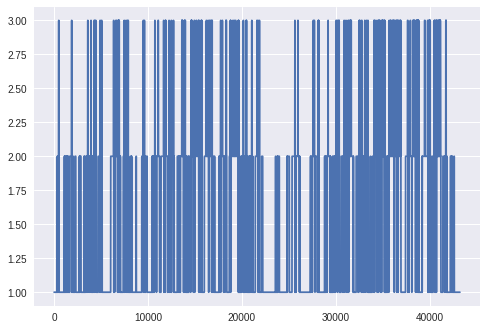

In [ ]:
submission_name = "nk_LSTM_all.csv"

print(f"Class 1: {np.sum(y_pred_filtered == 1)}")
print(f"Class 2: {np.sum(y_pred_filtered == 2)}")
print(f"Class 3: {np.sum(y_pred_filtered == 3)}")

y_pred_df = pd.DataFrame(y_pred_filtered)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)
    
"""
Class 1: 23933
Class 2: 18553
Class 3: 714
"""

In [ ]:
!ls

data  features	nk_LSTM.ipynb
